<a href="https://colab.research.google.com/github/NRJaggers/Applied-Stochastic-Processes/blob/main/Applications/4-Chutes_and_Ladders_and_MCMC/Chutes_and_Ladders_and_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chutes and Ladders and MCMC

---

## Prompt

Original Prompt can be found [here](https://bookdown.org/kevin_davisross/applied-stochastic-processes/app-mcmc.html). A copy of the prompt along with the completed exercise can be found under [/Applications](https://github.com/NRJaggers/Applied-Stochastic-Processes/tree/main/Applications).

##Summary

This investigation concerns the boardgame Chutes and Ladders. Detailed instructions and some code have been provided in original prompt; For detailed explaination, please be sure to read the full prompt carefully.

The board has 100 spaces, labeled 1, 2, …, 100. A player starts off the board. A player generally moves on the board according to the roll of a fair six-sided die. For example, if the player is currently on space 13 and they roll a 5, then they move to space 18. However, the board also has 9 ladders which help the player climb the board and 10 chutes (slides) which knock the player back down. The game ends when the player makes it to space 100. (We’ll assume only one player.)

###Problem 1

We are interested in $T$, the number of moves (rolls) needed until spot 100 is reached (the player doesn’t need to land on 100 exactly). The position of the player after the nth move can be modeled as a Markov chain with transition matrix `Pgame` defined in the code from the prompt.

###Problem 2

Suppose you were designing a new Chutes and Ladders board. How does the placement of the chutes and ladders on the board affect the expected value of $T$? In particular, is there a way to place the chutes/ladders to minimize the expected number of moves? In this problem, you’ll write an MCMC algorithm to find the board which minimizes $E(T)$.

---

## Application

###1.

First, create the Pgame matrix to use.

In [ ]:
#use this to allow for running R within Python
%load_ext rpy2.ipython

In [ ]:
%%R
N = 100 # number of spaces on board

s = N + 1  # number of states

k = 6  # number of sides on die

# P0 is the transition matrix if there were no chutes/ladders
P0 = matrix(rep(0, s * s), nrow = s)

for (i in 1:(N - 1)){
  for (j in min(i + 1, N):min(i + k, N)){
    if (j == N){
      P0[i, j] = (i - N + k + 1) / k
      # don't need to land on 100 exactly
    } else {
      P0[i, j] = 1 / k
    }
  }
}

P0[N, N] = 1  # absorbing state

P0[s, 1:k] = 1 / k  # initial state

In [ ]:
%%R
# The make_board function takes as an input the starting spaces
# for chutes and ladders and outputs the transition matrix
# add the chutes/ladders by swapping appropriate columns
# with an annoying little detail for the two short chutes
# e.g. you can get from 50 to 53 by rolling a 3
# or by rolling a 6 and then sliding down the chute from 56 to 53

make_board <- function(ladder_start, chute_start, plot = FALSE){
  ladder_length = c(8, 10, 16, 20, 20, 21, 22, 37, 56)
  ladder_end = ladder_start + ladder_length
  chute_length = c(3, 4, 10, 20, 20, 20, 22, 38, 43, 63)
  chute_end = chute_start - chute_length
  P = P0
  for (j in 1:length(ladder_start)){
    i = which(P[, ladder_start[j]] > 0)
    P[i, ladder_end[j]] = P[i, ladder_start[j]]
    P[i, ladder_start[j]] = 0
    P[ladder_start[j], ] = rep(0, s)
    P[ladder_start[j], ladder_end[j]]=1
  }
  for (j in 1:length(chute_start)){
    i = which(P[, chute_start[j]] > 0)
    i1 = i[which(i <= chute_end[j])]
    P[i1, chute_end[j]] = P[i1, chute_start[j]] +
      P0[i1, chute_end[j]]
    P[i1, chute_start[j]] = 0
    i2 = i[which(i > chute_end[j])]
    P[i2, chute_end[j]] = P[i2, chute_start[j]]
    P[i2, chute_start[j]] = 0
    P[chute_start[j], ] = rep(0, s)
    P[chute_start[j], chute_end[j]] = 1
  }
  if (plot == TRUE){
    image(1:s, 1:s, t(P[c(s, 1:(s - 1)), c(s, 1:(s - 1))]),
          xlab = "", ylab = "",
          zlim = c(1 / k, 1), xaxt = "n", yaxt = "n",
          col = rainbow(k))
    axis(1, at = 1:s, labels = 0:(s - 1), cex.axis=0.4)
    axis(2, at = 1:s, labels = 0:(s - 1), cex.axis=0.4)
    grid(s, s)
  }
  return(P)
}

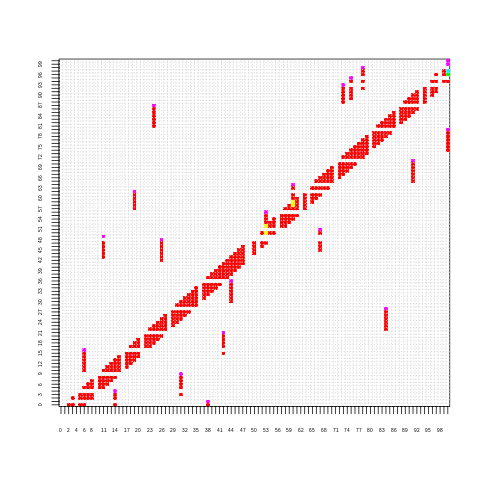

In [ ]:
#run in R environment but export output variable to python
%%R -o Pgame
# generate the transition matrix for the actual game
Pgame = make_board(
  ladder_start = c(36, 4, 51, 71, 80, 21, 9, 1, 28),
  chute_start = c(56, 64, 16, 93, 95, 98, 48, 49, 62, 87),
  plot = TRUE)

In [ ]:
%%R
# Check that all row sums are 1
Invalid_rows_n = which(!rowSums(Pgame) == 1)
print(Invalid_rows_n)

integer(0)


####a.

Solve for $E(T)$ without first finding the distribution of $T$.

In [ ]:
%%R
mean_time_to_absorption <- function(transition_matrix, state_names = NULL) {

  absorbing_states = which(diag(transition_matrix) == 1)

  if (length(absorbing_states) == 0) stop("There are no absorbing states.")

  n_states = nrow(transition_matrix)

  transient_states = setdiff(1:n_states, absorbing_states)

  Q = transition_matrix[transient_states, transient_states]

  mtta = solve(diag(nrow(Q)) - Q, rep(1, nrow(Q)))

  if (is.null(state_names)) state_names = 1:n_states

  data.frame(start_state = state_names[transient_states],
             mean_time_to_absorption = mtta)
}

In [ ]:
%%R
mu = mean_time_to_absorption(Pgame)
mu[100,]

    start_state mean_time_to_absorption
100         101                36.19307


Above we can see the mean absorbtion time, $E(T)$, from off the board to spot 100.

####b.

Solve for the exact distribution of $T$ and plot it. (Technically, $T$ can take infinitely many values, but feel free to cut off when the probabilities become sufficiently small.) Find $E(T)$ based on this distribution. Compare the expected value to the previous part.

In [ ]:
%%R
install.packages('expm')
install.packages('kableExtra')
install.packages('tidyverse')

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpt3r79s/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpt3r79s/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpt3r79s/downloaded_packages’



In [ ]:
%%R
library(expm)
library(kableExtra)

pmf_of_time_to_absorption <- function(transition_matrix, state_names = NULL, start_state) {

  absorbing_states = which(diag(transition_matrix) == 1)

  if (length(absorbing_states) == 0) stop("There are no absorbing states.")

  n_states = nrow(transition_matrix)

  transient_states = setdiff(1:n_states, absorbing_states)

  if (is.null(state_names)) state_names = 1:n_states

  if (which(state_names == start_state) %in% absorbing_states) stop("Initial state is an absorbing state; absorption at time 0.")

  n = 1

  TTA_cdf = sum(transition_matrix[which(state_names == start_state), absorbing_states])

  while (max(TTA_cdf) < 0.999999) {

    n = n + 1

    TTA_cdf = c(TTA_cdf, sum((transition_matrix %^% n)[which(state_names == start_state), absorbing_states]))
  }

  TTA_pmf = TTA_cdf - c(0, TTA_cdf[-length(TTA_cdf)])

  data.frame(n = 1:length(TTA_pmf),
             prob_absorb_at_time_n = TTA_pmf)
}


Attaching package: ‘expm’



    expm




In [ ]:
%%R
T_pmf = pmf_of_time_to_absorption(Pgame, start_state = 101)

T_pmf |> head(100)

      n prob_absorb_at_time_n
1     1           0.000000000
2     2           0.000000000
3     3           0.000000000
4     4           0.000000000
5     5           0.000000000
6     6           0.000000000
7     7           0.001971879
8     8           0.006174626
9     9           0.010176731
10   10           0.013461394
11   11           0.017124516
12   12           0.020461774
13   13           0.022348204
14   14           0.023169028
15   15           0.023949501
16   16           0.025097382
17   17           0.026294356
18   18           0.027100283
19   19           0.027427515
20   20           0.027474270
21   21           0.027397815
22   22           0.027177541
23   23           0.026731643
24   24           0.026059559
25   25           0.025252409
26   26           0.024409494
27   27           0.023574142
28   28           0.022739104
29   29           0.021888860
30   30           0.021027647
31   31           0.020176073
32   32           0.019353038
33   33   

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::unpack()     masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


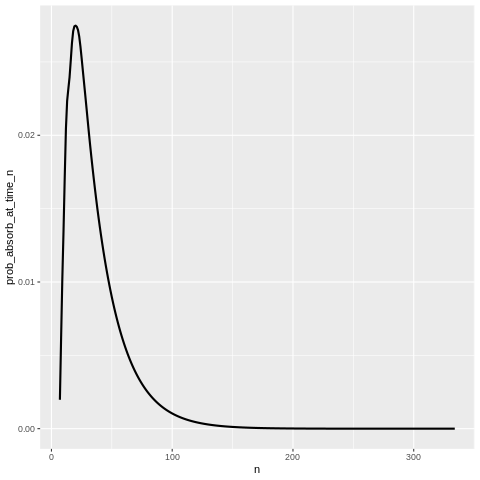

In [ ]:
%%R
library(tidyverse)

ggplot(T_pmf |>
         filter(prob_absorb_at_time_n > 0),
       aes(x = n,
           y = prob_absorb_at_time_n)) +
  geom_line(linewidth = 1)

In [ ]:
%%R
sum(T_pmf[, 1] * T_pmf[, 2])

[1] 36.19272


Both computation through absorbing state and cumulative PMF to find average result in values that agree. They both come out to be about 36.2 steps.

####c.

Write code to run the chain and simulate the distribution of $T$. Plot the simulated distribution, use it to estimate the expected value, and compare to the previous part.

In [ ]:
%%R
simulate_single_DTMC_path <- function(initial_distribution, transition_matrix, last_time){

  n_states = nrow(transition_matrix) # number of states

  states = 1:n_states # state space

  X = rep(NA, last_time + 1) # state at time n; +1 to include time 0

  X[1] = sample(states, 1, replace = TRUE, prob = initial_distribution) # initial state

  for (n in 2:(last_time + 1)){

    X[n] = sample(states, 1, replace = TRUE, prob = transition_matrix[X[n-1], ])

  }

  return(X)

}

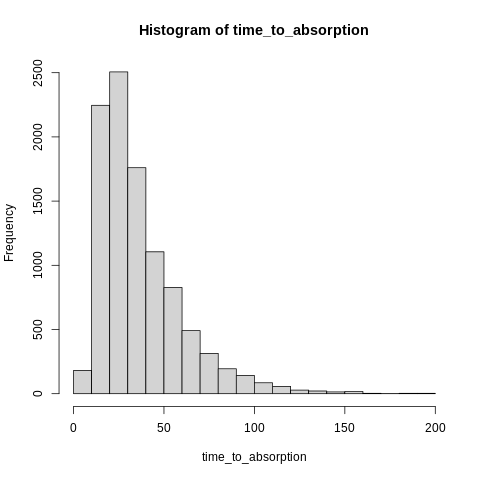

In [ ]:
%%R
pi0 <- rep(0, 101)
pi0[101] <- 1

absorbing_states = which(diag(Pgame) == 1)

n_rep = 10000
time_to_absorption = rep(NA, n_rep)

for (i in 1:n_rep) {
  x = simulate_single_DTMC_path(pi0, Pgame, last_time = 200)
  time_to_absorption[i] = min(which(x %in% absorbing_states))
}

hist(time_to_absorption)

In [ ]:
%%R
summary(time_to_absorption)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      8      21      31     Inf      47     Inf 


In [ ]:
%%R
mean(time_to_absorption)

[1] Inf


In [ ]:
%%R
sd(time_to_absorption)

[1] NaN


###2.

First, think about what the optimal placement might look like. Then, write an MCMC algorithm to find the board that minimizes $E(T)$. Your MCMC algorithm should involve:
- Proposing a new state, that is, proposing a new board. A board is identified by the starting spaces of the chutes and the starting spaces of the ladders (that is, the inputs to the `make_board` function).
- Finding the expected value of $T$ for the proposed board and then deciding whether or not to accept the proposed board. Note: if the proposed board is not valid (e.g., chutes/ladders land off the board), then it should be rejected.

Run the algorithm until you think it has converged and you have found the optimal board. Identify the the starting spaces for the chutes and ladders for this board.

####MCMC Algorithm

In [ ]:
# Function - create proposal and verify it is valid
%%R

propose_starting_locations <- function(ladder_start, chute_start) {
  # Find end for chutes and ladders
  ladder_length <- c(8, 10, 16, 20, 20, 21, 22, 37, 56)
  ladder_end <- ladder_start + ladder_length
  chute_length <- c(3, 4, 10, 20, 20, 20, 22, 38, 43, 63)
  chute_end <- chute_start - chute_length

  # Randomly choose chutes or ladders to adjust
  adjust_type <- sample(c("ladder", "chute"), 1)

  # Randomly pick which element to adjust
  if (adjust_type == "ladder") {
    element_index <- sample(length(ladder_length), 1)
    start <- 1
    end   <- 100 - ladder_length[element_index]
    new_start <- sample(start:end, 1)  # Generate new starting position
    new_end   <- new_start + ladder_length[element_index]
    while (new_start %in% c(ladder_start, ladder_end, chute_start, chute_end) ||
           new_end %in% c(ladder_start, ladder_end, chute_start, chute_end)) {
      new_start <- sample(start:end, 1)  # Regenerate if position is not valid
      new_end   <- new_start + ladder_length[element_index]
    }
    new_ladder_start <- replace(ladder_start, element_index, new_start)
    new_chute_start  <- chute_start  # Chute positions remain unchanged
  } else {
    element_index <- sample(length(chute_length), 1)
    start <- 4 + chute_length[element_index]
    end   <- 99
    new_start <- sample(start:end, 1)  # Generate new starting position
    new_end   <- new_start - chute_length[element_index]
    while (new_start %in% c(ladder_start, ladder_end, chute_start, chute_end) ||
           new_end %in% c(ladder_start, ladder_end, chute_start, chute_end)) {
      new_start <- sample(start:end, 1)  # Regenerate if position is not valid
      new_end   <- new_start - chute_length[element_index]
    }
    new_chute_start  <- replace(chute_start, element_index, new_start)
    new_ladder_start <- ladder_start  # Ladder positions remain unchanged
  }

  # Return a list containing the new starting locations for ladders and chutes
  return(list(new_ladder_start = new_ladder_start, new_chute_start = new_chute_start))
}


# Example usage:
ladder_start <- c(36, 4, 51, 71, 80, 21, 9, 1, 28)
chute_start <- c(56, 64, 16, 93, 95, 98, 48, 49, 62, 87)

result <- propose_starting_locations(ladder_start, chute_start)
new_ladder_start <- result$new_ladder_start
new_chute_start <- result$new_chute_start

# Print the new starting locations
ladder_length <- c(8, 10, 16, 20, 20, 21, 22, 37, 56)
chute_length <- c(3, 4, 10, 20, 20, 20, 22, 38, 43, 63)

print(ladder_start)
print(new_ladder_start)
print(ladder_length)
print(new_ladder_start+ladder_length)

print(chute_start)
print(new_chute_start)
print(chute_length)
print(new_chute_start-chute_length)


[1] 36  4 51 71 80 21  9  1 28
[1] 36  4 51 71 80 61  9  1 28
[1]  8 10 16 20 20 21 22 37 56
[1]  44  14  67  91 100  82  31  38  84
 [1] 56 64 16 93 95 98 48 49 62 87
 [1] 56 64 16 93 95 98 48 49 62 87
 [1]  3  4 10 20 20 20 22 38 43 63
 [1] 53 60  6 73 75 78 26 11 19 24


In [ ]:
%%R
Pgame = make_board(new_ladder_start, new_chute_start, plot = FALSE)

# Check that all row sums are 1
Invalid_rows_n = which(!rowSums(Pgame) == 1)
print(Invalid_rows_n)

integer(0)


In [ ]:
#run MCMC algorithm and find min E(T)
%%R

#start with original board
ladder_start = c(36, 4, 51, 71, 80, 21, 9, 1, 28)
chute_start = c(56, 64, 16, 93, 95, 98, 48, 49, 62, 87)
Pgame = make_board(ladder_start, chute_start, plot = FALSE)

mu = mean_time_to_absorption(Pgame)
T_curr = mu[100,2]

T_min = T_curr
Pgame_min = Pgame


#run simulation for number of steps and find min T
sim_length = 50000
for (i in 1:sim_length){

    #propose new board
    result <- propose_starting_locations(ladder_start, chute_start)
    new_ladder_start <- result$new_ladder_start
    new_chute_start <- result$new_chute_start

    #make the board and find T
    Pgame = make_board(new_ladder_start, new_chute_start, plot = FALSE)
    mu = mean_time_to_absorption(Pgame)
    T_prop = mu[100,2]

    #test if it is a minimum
    if (T_prop < T_min)
    {
        T_min = T_prop
        ladder_min = new_ladder_start
        chute_min = new_chute_start
    }

    #determine acceptance probability and get determination
    a = min((1/T_prop)/(1/T_curr),1)
    action = sample(c("reject", "accept"), 1, prob = c(1 - a, a))

    if (action == "accept"){
      ladder_start = new_ladder_start
      chute_start = new_chute_start
      T_curr = T_prop
    }

}

####Comparison

Repeat Problem 1 for your optimal board, and compare the distribution of $T$ for your board to the one from the actual game. Write a few sentences summarizing your results.

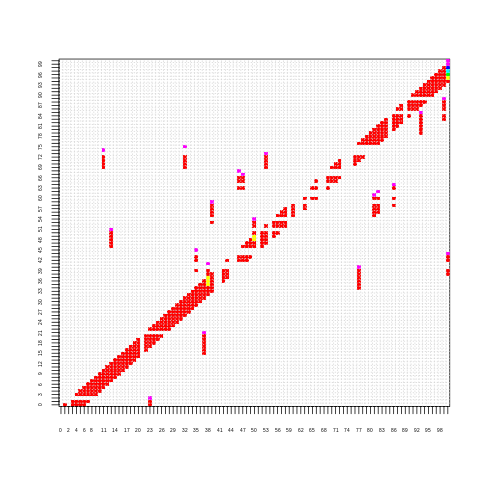

In [ ]:
%%R
Pgame_min = make_board(ladder_min, chute_min, plot = TRUE)


In [ ]:
%%R
# Check that all row sums are 1
Invalid_rows_n = which(!rowSums(Pgame_min) == 1)
print(Invalid_rows_n)

integer(0)


#####a.

Solve for $E(T)$ without first finding the distribution of $T$.

In [ ]:
%%R
mu = mean_time_to_absorption(Pgame_min)
T = mu[100,]
print(T)

    start_state mean_time_to_absorption
100         101                17.83413


#####b.

Solve for the exact distribution of $T$ and plot it.  Find $E(T)$ based on this distribution.

In [ ]:
%%R
T_pmf = pmf_of_time_to_absorption(Pgame_min, start_state = 101)

T_pmf |> head(100)

      n prob_absorb_at_time_n
1     1          0.000000e+00
2     2          0.000000e+00
3     3          0.000000e+00
4     4          0.000000e+00
5     5          2.186214e-03
6     6          1.170267e-02
7     7          2.328032e-02
8     8          2.659298e-02
9     9          2.641586e-02
10   10          3.443945e-02
11   11          5.001825e-02
12   12          6.213051e-02
13   13          6.542704e-02
14   14          6.419891e-02
15   15          6.378954e-02
16   16          6.475766e-02
17   17          6.443225e-02
18   18          6.082339e-02
19   19          5.435482e-02
20   20          4.686062e-02
21   21          3.985258e-02
22   22          3.383119e-02
23   23          2.868565e-02
24   24          2.426285e-02
25   25          2.054415e-02
26   26          1.753012e-02
27   27          1.512991e-02
28   28          1.317664e-02
29   29          1.150970e-02
30   30          1.003176e-02
31   31          8.708411e-03
32   32          7.535621e-03
33   33   

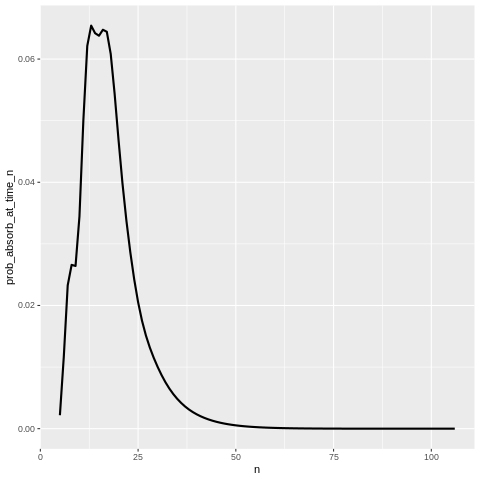

In [ ]:
%%R
library(tidyverse)

ggplot(T_pmf |>
         filter(prob_absorb_at_time_n > 0),
       aes(x = n,
           y = prob_absorb_at_time_n)) +
  geom_line(linewidth = 1)

In [ ]:
%%R
sum(T_pmf[, 1] * T_pmf[, 2])

[1] 17.83402


#####c.

Write code to run the chain and simulate the distribution of $T$. Plot the simulated distribution, use it to estimate the expected value.

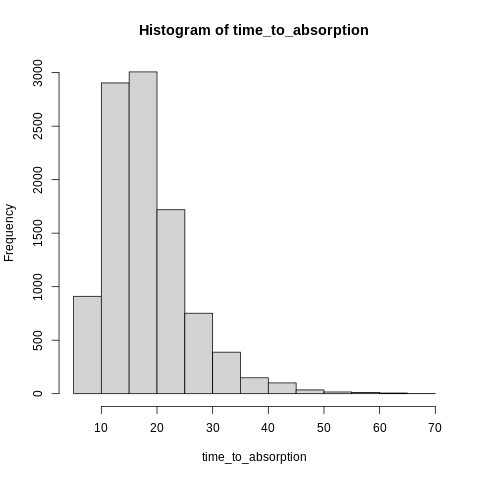

In [30]:
%%R
pi0 <- rep(0, 101)
pi0[101] <- 1

absorbing_states = which(diag(Pgame_min) == 1)

n_rep = 10000
time_to_absorption = rep(NA, n_rep)

for (i in 1:n_rep) {
  x = simulate_single_DTMC_path(pi0, Pgame_min, last_time = 200)
  time_to_absorption[i] = min(which(x %in% absorbing_states))
}

hist(time_to_absorption)

In [31]:
%%R
summary(time_to_absorption)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00   14.00   17.00   18.64   22.00   69.00 
